In [60]:
%matplotlib inline

import os
import glob
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.contrib import layers
from tensorflow.contrib import slim

import matplotlib.pyplot as plt

import util
import gan_util
import gan
import dataset_util
import mnist_dataset

reload(util);
reload(gan_util);
reload(gan);
reload(dataset_util);
reload(mnist_dataset);


def plot_digits(digits):
    plt.figure(figsize=(20, 20))
    plt.axis('off')
    plt.imshow(
        np.concatenate([x[:,:,0] for x in digits], axis=1), 
        cmap='gray')
    plt.show()

# Train

In [ ]:
def make_generator(noise, label, is_training):
    with slim.arg_scope(
        [layers.conv2d_transpose],
        activation_fn=tf.nn.relu,
        normalizer_fn=layers.batch_norm,
        normalizer_params={'is_training': is_training,
                           'updates_collections': None}):
        top = tf.concat(
            noise.embed(cont_dims=[512], cat_dims=[8], name='noise') +
            label.embed(cont_dims=[512], cat_dims=[8], name='label'), axis=1)
        top = tf.reshape(top, [-1, 1, 1, util.get_flatten_dim(top)])
        top = layers.conv2d_transpose(top, 128, [3, 3], stride=1, padding='VALID')
        top = layers.conv2d_transpose(top, 64, [5, 5], stride=1, padding='VALID')
        top = layers.conv2d_transpose(top, 32, [5, 5], stride=2, padding='SAME')
        top = layers.conv2d_transpose(top, 1, [5, 5], stride=2, padding='SAME',
                                      activation_fn=None, normalizer_fn=None)
        top = tf.sigmoid(top)
        
        return top


def make_discriminator(data, noise, label, is_training):
    with slim.arg_scope(
        [layers.conv2d],
        activation_fn=tf.nn.relu,
        normalizer_fn=layers.batch_norm,
        normalizer_params={'is_training': is_training,
                           'updates_collections': None}):
    
        top = data
        top = layers.conv2d(top, 32, [5, 5], stride=2, padding='SAME')
        top = layers.conv2d(top, 64, [5, 5], stride=2, padding='SAME')
        top = layers.conv2d(top, 128, [5, 5], stride=1, padding='VALID')
        top = layers.flatten(top)
        top = layers.fully_connected(top, 1024)
        
        data_logit = util.linear(top, 1)
        
        return data_logit, label.linear_output([top], [top])


train_dir = 'mnist_logs'
shutil.rmtree(train_dir, ignore_errors=True)
batch_size = 32
noise_dim = 100
with tf.Graph().as_default():
    dataset = mnist_dataset.Dataset('../mnist')
    ds = dataset_util.repeat_shuffle_batch(
        dataset.raw, batch_size=batch_size)
    iterator = ds.make_initializable_iterator()
    next_elem = iterator.get_next()
    image, label = (next_elem[mnist_dataset.IMAGE_KEY],
                    next_elem[mnist_dataset.LABEL_KEY])
    
    real_data = util.set_first_dim(image, batch_size)
    real_label = gan_util.Signal(
        [],
        [
            gan_util.CatVector(
                util.set_first_dim(label, batch_size), 10)
        ])
    fake_noise = gan_util.Signal(
        [
            tf.random_normal(shape=(batch_size, noise_dim))
        ], [])
    fake_label = real_label
    model = gan.make_gan_model(
        make_generator,
        make_discriminator,
        fake_noise,
        fake_label,
        real_data,
        real_label)
    
    # Add test variables to collections
    tf.add_to_collection('mnist.label', model.test_label.cat_vectors[0].sparse)
    tf.add_to_collection('mnist.noise', model.test_noise.cont_tensors[0])
    tf.add_to_collection('mnist.data', model.test_data)
    
    global_step = tf.contrib.framework.get_or_create_global_step()
    g_train_op, d_train_op = model.train_ops(
        tf.train.AdamOptimizer(1.0e-3, beta1=0.5),
        tf.train.AdamOptimizer(1.0e-3, beta1=0.5),
        global_step)
    
    tf.summary.scalar('generator_loss', model.generator_loss)
    tf.summary.scalar('discriminator_loss', model.discriminator_loss)
    summary_op = tf.summary.merge_all()
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.tables_initializer(), feed_dict=dataset.feed_dict)
        sess.run(iterator.initializer, feed_dict=dataset.feed_dict)
        
        summary_writer = tf.summary.FileWriter(
            logdir=train_dir, graph=sess.graph)
        
        with util.TensorflowQueues(sess):
            step = 0
            while step < 10000:
                _, d_loss, d_losses = sess.run([
                    d_train_op,
                    model.discriminator_loss,
                    model.discriminator_losses])
        
                _, g_loss, g_losses = sess.run([
                    g_train_op,
                    model.generator_loss,
                    model.generator_losses])
            
                step = sess.run(global_step)
                if step % 100 == 0:
                    print 'Global step {}: g_loss = {}, d_loss = {}'.format(
                        step, g_loss, d_loss)

                    print 'Writing summaries'
                    summary_proto = sess.run(summary_op)
                    summary_writer.add_summary(summary_proto, global_step=step)
                        
                    print 'Writing checkpoint'
                    saver.save(sess, os.path.join(train_dir, 'model'), global_step=step)
                    
                    feed_dict = model.test_noise.feed_dict([
                        np.random.normal(size=(10, noise_dim))
                    ], [])
                    feed_dict.update(model.test_label.feed_dict([], [
                        np.arange(10)
                    ]))
                    test_data = sess.run(model.test_data, feed_dict=feed_dict)
                    plot_digits(test_data)
                    
                    print '='*50

# Test

In [68]:
class MnistInference(object):
    
    def __init__(self, train_log):
        self._graph = tf.Graph()
        self._sess = tf.Session(graph=self._graph)
        with self._graph.as_default():
            ckpt = tf.train.latest_checkpoint(train_log)
            saver = tf.train.import_meta_graph(ckpt + '.meta')
            saver.restore(self._sess, ckpt)
            
            self._label_placeholder = tf.get_collection('mnist.label')[0]
            self._noise_placeholder = tf.get_collection('mnist.noise')[0]
            self._noise_dim = self._noise_placeholder.get_shape()[1]
            self._data = tf.get_collection('mnist.data')[0]
            
    def cleanup(self):
        self._sess.close()
            
    def __enter__(self):
        return self
    
    def __exit__(self, exc_type, exc_value, exc_traceback):
        self.cleanup()
    
    def run(self, label, noise=None):
        label = np.asarray(label)
        batch_size = label.shape[0]
        if noise is None:
            noise = np.random.normal(
                size=(batch_size, self._noise_dim))
        feed_dict = {
            self._noise_placeholder: noise,
            self._label_placeholder: label
        }
        data = self._sess.run(self._data, feed_dict=feed_dict)
        return data, noise
    

mnist_inference = MnistInference('mnist_logs')

INFO:tensorflow:Restoring parameters from mnist_logs/model-10000


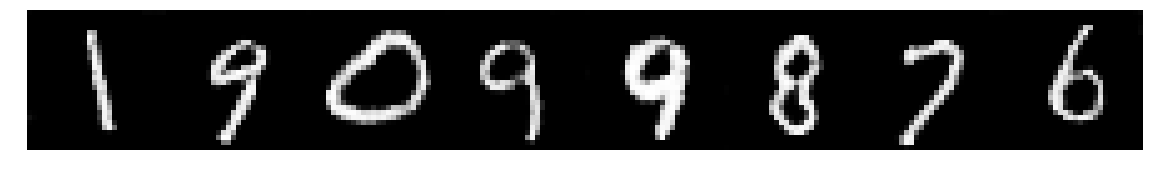

In [71]:
plot_digits(mnist_inference.run([1,9,0,9,9,8,7,6])[0])

In [66]:
mnist_inference.cleanup()